# MULTICLASS CLASSIFIER USING CNN for the SVHN Dataset


In [ ]:
pip install keras-tuner --upgrade;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.3 MB/s eta 0:00:00


In [ ]:
# Necessary imports

import tensorflow as tf
from scipy.io import loadmat
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense, Input, Activation
from tensorflow.keras.models import Sequential

###### The datasets (train and test set) needed for this project were downloaded from this link: http://ufldl.stanford.edu/housenumbers/train.tar.gz. They were then unzipped and stored in gdrive for use in this colab notebook.

In [ ]:
# Run this to connect the drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###1. Extracting, Transforming and Loading(ETL) of the image data.

In [ ]:
# Load the dataset from drive folder

train = loadmat('/content/gdrive/MyDrive/tf_coursera/tf1_project/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/tf_coursera/tf1_project/test_32x32.mat')

In [ ]:
# Both train and test sets are dictionaries with X for images and y for labels
print('The type of train data is:',type(train))
print('The type of test data is :',type(test))

print()

train_keys = [key for key in train.keys()]
print("Keys of train dataset:\n")
print(train_keys)

print()
test_keys = [key for key in test.keys()]
print("keys of test dataset:\n")
print(test_keys)



The type of train data is: <class 'dict'>
The type of test data is : <class 'dict'>

Keys of train dataset:

['__header__', '__version__', '__globals__', 'X', 'y']

keys of test dataset:

['__header__', '__version__', '__globals__', 'X', 'y']


Both train and test sets are dictionaries with X for images and y for labels.


In [ ]:
# Extracting train,test images and labels from train. test dictionaries

train_images = train['X']
train_labels = train['y']
test_images = test['X']
test_labels = test['y']

In [ ]:
# Inspect shapes
print("Train images dataset shape: ",train_images.shape)
print("Train labels dataset shape: ",train_labels.shape)
print("Test images dataset shape: ",test_images.shape)
print("Test labels dataset shape: ",test_labels.shape)

Train images dataset shape:  (32, 32, 3, 73257)
Train labels dataset shape:  (73257, 1)
Test images dataset shape:  (32, 32, 3, 26032)
Test labels dataset shape:  (26032, 1)


In [ ]:
train_images_trans = train_images.transpose((3,0,1,2))
train_images_trans.shape

(73257, 32, 32, 3)

Text(0.5, 1.0, 'Image label: 2')

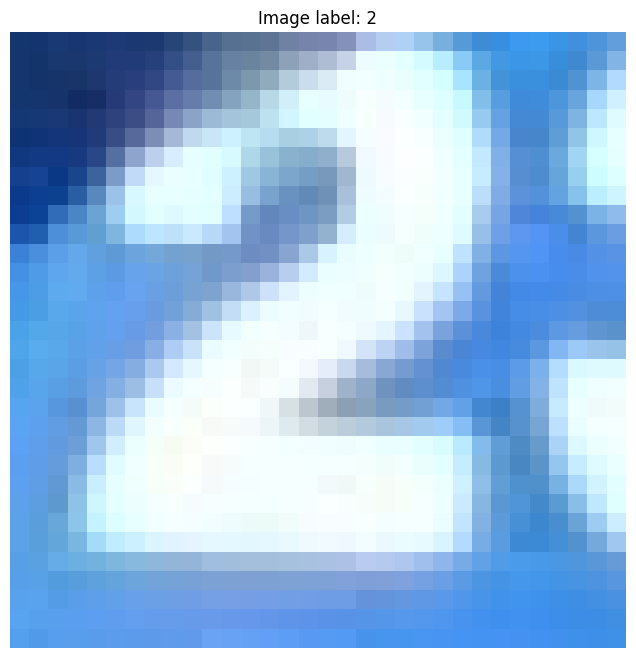

In [ ]:
# try displaying an image with this transposed
sample = train_images_trans[2,:,:,:].reshape((32,32,3))
fig = plt.figure(figsize=(8,8))
plt.imshow((sample).astype(np.uint8))
plt.axis("off")
plt.title(f"Image label: {train_labels[2][0]}")

In [ ]:
# (32,32,3,N) changed to (N,32,32,3)

new_train_images = train_images.transpose((3,0,1,2))
new_test_images = test_images.transpose((3,0,1,2))
print(new_train_images.shape)
print(new_test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


In [ ]:
# the initial labels in both train and test data set are 1 to 10; 10 means digit 0.

print(train_labels.min())
print(train_labels.max())
print(test_labels.min())
print(test_labels.max())
print(train_labels[0][0])

0
9
0
9
1


In [ ]:
# Change label 10 to label 0 so that label 0 means 0 digit.

print(train_labels.min())
print(train_labels.max())
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

0
9


In [ ]:
print(train_labels.min())
print(train_labels.max())
print(train_labels[0][0])

0
9
1


Selecting 10 random images and their corresponding labels from train dataset and displaying them in a figure after the dimension of the train dataset has been changed.

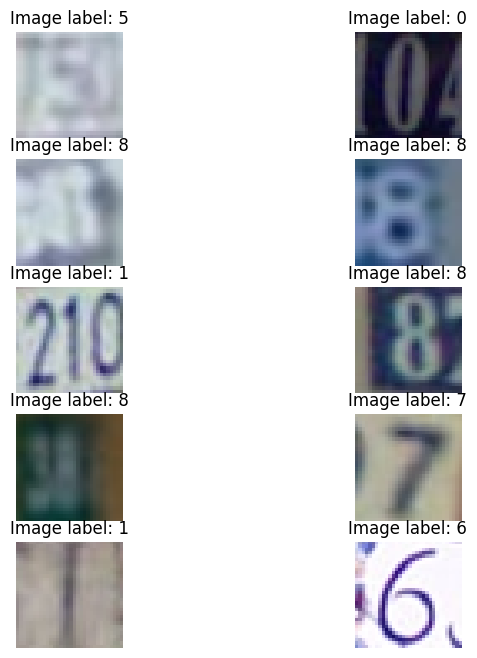

In [ ]:
# Selecting 10 random images and their corresponding labels from train dataset and displaying them in a figure
# display after dimension change

fig = plt.figure(figsize=(8,8))
nrows=5
ncols=2
train_labels_total = train_labels.shape[0]

for j in range(10):
  #add the subplot
  fig.add_subplot(nrows, ncols, j+1)
  # display a random image in the subplot
  random_index = np.random.choice(train_labels_total, size=1, replace=False)
  out = new_train_images[random_index,:,:,:].reshape((32,32,3))
  plt.imshow((out).astype(np.uint8))
  plt.axis("off")
  plt.title(f"Image label: {train_labels[random_index][0][0]}")

Reducing the color dimension from 3 to 1, by taking average across RBG channels.

In [ ]:
def reduce_color_channel(images,labels):
    """
    This function takes mean across all color channels and converts 3 channels to 1. by taking
    colored image dataset and labels in the argument.
    """
    labels_total = labels.shape[0]
    images_reduce = np.zeros((labels_total, 32,32,1))

    for i in range(labels_total):
      img = images[i,:,:,:]
      img = img.reshape((32,32,3))
      img = np.mean(img,axis=2)
      img = img.reshape((32,32,1))
      images_reduce[i,:,:,:] = img[:,:,:]

    return images_reduce

In [ ]:
# reducing the color dimension from 3 to 1.
# (N, 32, 32, 3) dataset changes to (N, 32, 32, 1)
# not grey-scaling but rather averaging across the color dimension


test_images_reduce = reduce_color_channel(new_test_images, test_labels) #dimension changed earlier now grayscale formed
train_images_reduce = reduce_color_channel(new_train_images, train_labels)
print("Shape of train dataset after reducing color dimension is ",train_images_reduce.shape)  #color dimension of one retained to feed to CNN
print("Shape of test dataset after reducing color dimension is", test_images_reduce.shape)

Shape of train dataset after reducing color dimension is  (73257, 32, 32, 1)
Shape of test dataset after reducing color dimension is (26032, 32, 32, 1)


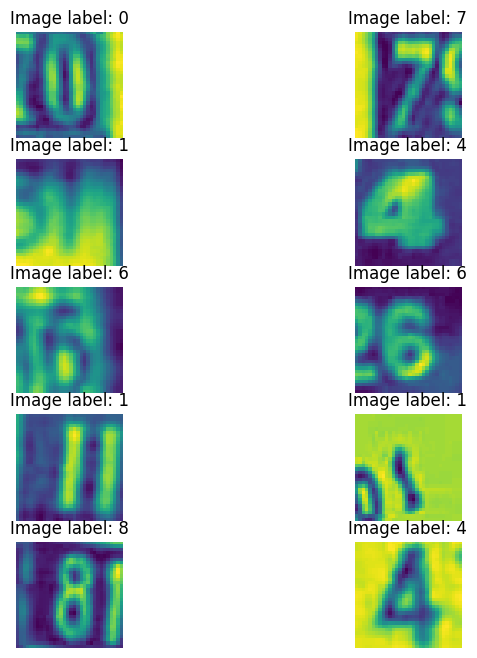

In [ ]:
# display 10 random images after color channel has been reduced to 1

fig = plt.figure(figsize=(8,8))
nrows=5
ncols=2
train_labels_total = train_labels.shape[0]

for j in range(10):
  #add the subplot
  fig.add_subplot(nrows, ncols, j+1)
  # display a random image in the subplot
  random_index = np.random.choice(train_labels_total, size=1, replace=False)
  out = train_images_reduce[random_index,:,:,:].reshape((32,32))
  plt.imshow((out).astype(np.uint8))
  plt.axis("off")
  plt.title(f"Image label: {train_labels[random_index][0][0]}")

### 2. CNN neural network classifier

Defining three functions each of which return different type of Callback objects.

*   get_checkpoint_best_only: Returns ModelCheckpoint callback object that saves best weights( weights that correspond to lowest loss).

*   get_checkpoint_every_epoch: Returns ModelCheckpoint callback object that saves the weights at the end of every epoch.

*   get_early_stopping: Returns EarlyStopping callback object that stops the training when loss has not improved in the last *specified number of* epochs.




In [ ]:
def get_checkpoint_best_only():
  """
    This function returns ModelCheckpoint object that:
    - saves only the weights that generate the lowest loss
    - saves into the directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint'
    """

  checkpoint_best_path = 'checkpoints_best_only/checkpoint'  #change for your need
  checkpoint_best_only = ModelCheckpoint(filepath=checkpoint_best_path,
                                         save_weight_only=True,
                                         verbose=1,
                                         monitor="val_loss",
                                         mode="min",
                                         save_best_only=True,
                                         save_freq="epoch")

  return checkpoint_best_only

In [ ]:
def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    checkpoint_epoch_path = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'  #change for your need
    checkpoint_every_epoch = ModelCheckpoint(filepath= checkpoint_epoch_path,
                                      save_weights_only= True,
                                      save_freq= "epoch",
                                      verbose=0)

    return checkpoint_every_epoch

In [ ]:
def get_early_stopping(p=5):
  """
  This function returns a Earlystopping callback that stops the training when loss
  has not improved in the last p number of epochs.
  """
  early_stopping = EarlyStopping(monitor="val_loss",
                                 mode="min",
                                 patience=p,
                                 verbose=1)

  return early_stopping

In [ ]:
# generating instance of each callback objects

best_only = get_checkpoint_best_only()
every_epoch = get_checkpoint_every_epoch()
early_stopping = get_early_stopping(p=5)

In [ ]:

callbacks = [best_only, every_epoch, early_stopping]


In [ ]:
# input shape
input_shape = train_images_reduce[1,:,:,:].shape
print(input_shape)

(32, 32, 1)


### Defining a CNN model.

In [ ]:

# define the first set of CONV => POOL layers
model =Sequential()
model.add(Conv2D(20, 5, padding="same", input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# define the second set of CONV  => POOL layers
model.add(Conv2D(50, 5, padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation("softmax"))


In [ ]:
#compiling the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Using Keras Tuner.

In [ ]:
def model_tuner(hp):

    model = keras.Sequential([

    #adding first convolutional layer
    keras.layers.Conv2D(
        #adding filter
        filters=hp.Int('conv_1_filter', min_value=20, max_value=120, step=10),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [2,3,5]),
        #activation function
        activation='relu',
        input_shape=(32,32,1)),

    keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    #Dropout(rate = hp.Choice('drop_rate_1', values=[0.3, 0.4, 0.5])),


    # adding second convolutional layer
    keras.layers.Conv2D(
        #adding filter
        filters=hp.Int('conv_2_filter', min_value=20, max_value=80, step=10),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [2,3,5]),
        #activation function
        activation='relu',
    ),

    keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    #Dropout(rate = hp.Choice('drop_rate_2', values=[0.3, 0.4, 0.5])),

    # adding flatten layer
    keras.layers.Flatten(),
    # adding dense layer
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=100, max_value=500, step=50),
        activation='relu'
    ),
    # output layer
    keras.layers.Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 1e-5])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
#initialize the tuner

import keras_tuner

from tensorflow import keras
#creating randomsearch object
tuner = keras_tuner.RandomSearch(model_tuner,
                    objective='val_accuracy',
                    max_trials = 15)


Using TensorFlow backend


In [ ]:
# make a subset of training images as validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images_reduce, train_labels, test_size=0.25, random_state=42, stratify=train_labels)



In [ ]:

# search best parameter
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 15 Complete [00h 02m 24s]
val_accuracy: 0.8928201198577881

Best val_accuracy So Far: 0.8997542858123779
Total elapsed time: 00h 34m 19s


In [ ]:
model_tuned=tuner.get_best_models(num_models=1)[0]
#summary of best model
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 70)        700       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 70)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 15, 15, 70)        280       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 80)        50480     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 80)          0         
 g2D)                                                            
                                                        

In [ ]:
model_tuned=tuner.get_best_models(num_models=1)[0]
#summary of best model
model_tuned.summary()

### After tuning

In [45]:
#best model from tuning
# define the best set of CONV => POOL layers
def create_model():

  model =Sequential()
  model.add(Conv2D(70, 5, padding="same", input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

  # define the second set of CONV  => POOL layers
  model.add(Conv2D(80, 5, padding="same"))
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

  model.add(Flatten())
  model.add(Dense(200))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation("softmax"))

  return model

In [59]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#history = model.fit(train_images_reduce, train_labels, epochs=40, batch_size=64,
#                        verbose=1,
#                        validation_split=0.10, callbacks=[callbacks])

In [61]:
history = model.fit(train_images_reduce, train_labels, epochs=30, batch_size=64,
                        verbose=1,
                        validation_split=0.20)

Epoch 1/30
916/916 [==============================] - 9s 9ms/step - loss: 1.6314 - accuracy: 0.5504 - val_loss: 0.8224 - val_accuracy: 0.7594
Epoch 2/30
916/916 [==============================] - 8s 8ms/step - loss: 0.6788 - accuracy: 0.8035 - val_loss: 0.6191 - val_accuracy: 0.8279
Epoch 3/30
916/916 [==============================] - 8s 8ms/step - loss: 0.5550 - accuracy: 0.8408 - val_loss: 0.5539 - val_accuracy: 0.8456
Epoch 4/30
916/916 [==============================] - 7s 7ms/step - loss: 0.4838 - accuracy: 0.8618 - val_loss: 0.5229 - val_accuracy: 0.8538
Epoch 5/30
916/916 [==============================] - 7s 8ms/step - loss: 0.4306 - accuracy: 0.8774 - val_loss: 0.4741 - val_accuracy: 0.8717
Epoch 6/30
916/916 [==============================] - 7s 8ms/step - loss: 0.3852 - accuracy: 0.8907 - val_loss: 0.4576 - val_accuracy: 0.8765
Epoch 7/30
916/916 [==============================] - 8s 8ms/step - loss: 0.3492 - accuracy: 0.9009 - val_loss: 0.4578 - val_accuracy: 0.8756
Epoch 

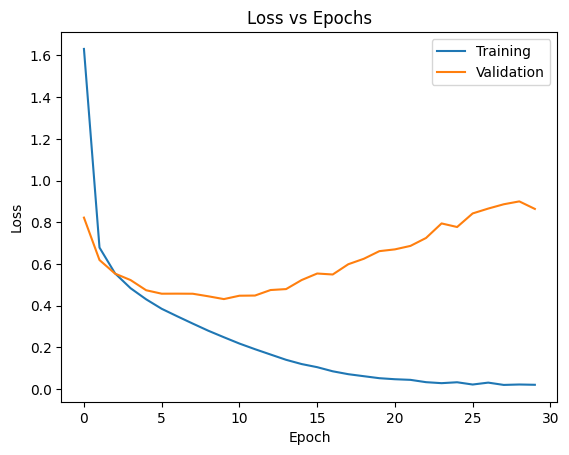

In [62]:
#Plot loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"], loc='upper right')
plt.show()

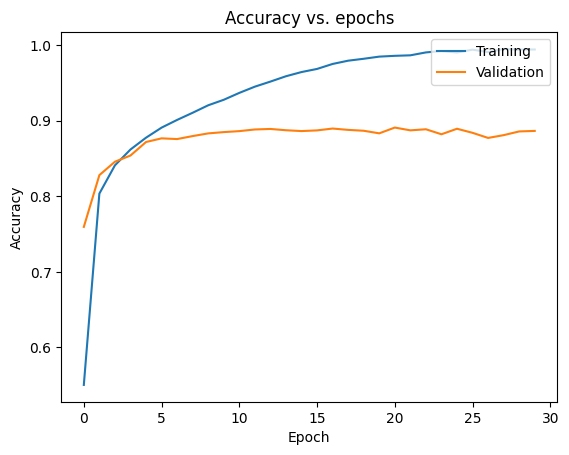

In [63]:
#Plot accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Saving the model.


In [64]:
# Save the model to a file using pickle
import pickle
pickle.dump(model, open('/content/gdrive/MyDrive/Colab Notebooks/CNN_SVHN_dep/pickle_CNN_SVHN_dep.pickle', 'wb'))

# Save the trained model as an HDF5 file
model.save('/content/gdrive/MyDrive/Colab Notebooks/CNN_SVHN_dep/h5_CNN_SVHN.h5')

#change the filepath as per your need.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 3. Getting model predictions

Loading the model.

In [65]:
model_cnn_new = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/CNN_SVHN_dep/h5_CNN_SVHN.h5')

Randomly selecting 5 test images and and their corresponding labels.
Alongside the image and label, the models predictive distribution is shown as bar chart.

1/1 [==============================] - 0s 19ms/step


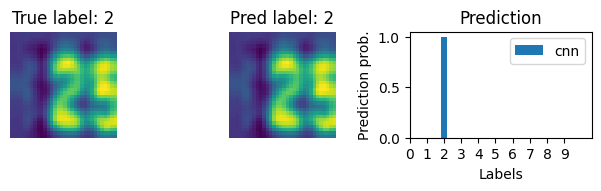

1/1 [==============================] - 0s 21ms/step


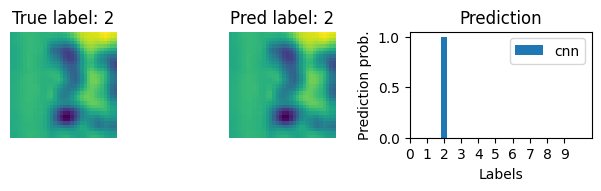

1/1 [==============================] - 0s 27ms/step


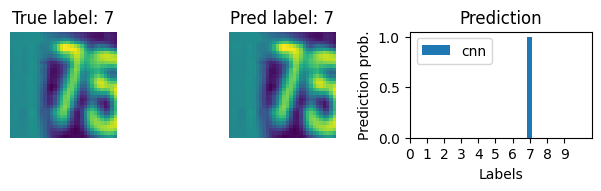

1/1 [==============================] - 0s 26ms/step


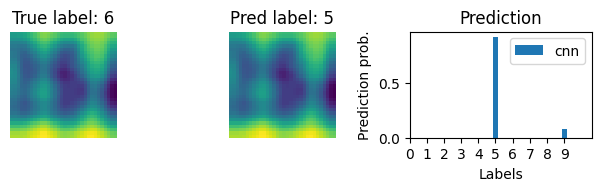

1/1 [==============================] - 0s 27ms/step


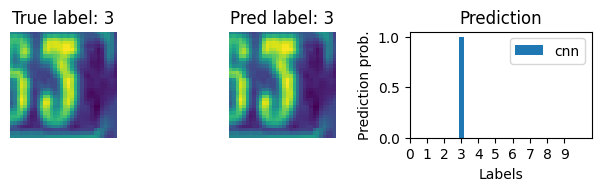

In [67]:
# Randomly select 5 test images and and their corresponding labels
# Along with the image and label, the models predictive distribution is shown as bar chart

t = 5 #number of test images to display
test_labels_total = test_labels.shape[0]

for i in range(t):

  #randomly select test image
  random_index = np.random.choice(test_labels_total, size=1, replace=False)
  p = random_index
  test_image = test_images_reduce[p,:,:,:]

  #get prediction on that image
  pred_cnn = model_cnn_new.predict(test_image) #[1,32,32,1]
  pred_cnn_2 = np.reshape(pred_cnn, (10, ))
  y_cnn = pred_cnn_2.tolist()
  y_cnn_2 = y_cnn[1:]
  z = y_cnn[0]
  y_cnn_2.append(z)
  x_pos = np.arange(0,10)

  #for each image put three subplots(image & actual label), (bar chart of distribution) and (image & predicted label)

  fig = plt.figure(figsize=(8,8))
  nrows = t
  ncols = 3

  #plot the actual image and its true label

  j = i*3                      #[0,3,6,9,12]

  fig.add_subplot(nrows, ncols, j+1)
  test = test_image.reshape((32,32))
  plt.imshow(test.astype(np.uint8))
  plt.axis("off")
  true_label = test_labels[p][0][0]
  #if true_label == 0:
  #  true_label = 10
  plt.title(f"True label: {true_label}")


  #plot the actual image and its predicted label
  prob_cnn = np.max(pred_cnn_2)
  pred_label = np.argmax(pred_cnn)
  #if pred_label == 0:
  #  pred_label = 10


  fig.add_subplot(nrows, ncols, j+2)
  test = test_image.reshape((32,32))
  plt.imshow(test.astype(np.uint8))
  plt.axis("off")
  plt.title(f"Pred label: {pred_label}")


  #plot bar chart of prediction distribution
  fig.add_subplot(nrows, ncols, j+3)
  plt.bar(x_pos+1, y_cnn_2, width=0.3, label='cnn')
  plt.xticks(x_pos)
  plt.legend()
  plt.xlabel('Labels')
  plt.ylabel('Prediction prob.') #prediction probability
  plt.title("Prediction") #prediction distribution
  plt.show()

Getting total prediction accuracy.

In [68]:
# Getting total prediction accuracy

pred_cnn_all = model_cnn_new.predict(test_images_reduce)  #(26032, 10)

test_labels[test_labels==10] == 0
test_labels_reshaped = test_labels.reshape((26032,))

ind_max = np.argmax(pred_cnn_all, axis=1)  #(26032,0)

total_correct = np.sum(test_labels_reshaped == ind_max)
prediction_accuracy = total_correct * 100 / test_labels_reshaped.size

print(f"Prediction Accuracy is: {prediction_accuracy} %")

814/814 [==============================] - 2s 2ms/step
Prediction Accuracy is: 87.0159803318992 %


In [ ]:
#git commit -m "CNN SVHN_wit"